In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew 
from sklearn import linear_model
#from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler

In [2]:
# read the data sets
training = pd.read_csv('Data/train.csv')
testing = pd.read_csv('Data/test.csv')
id_col = testing['Id'].values

### 1. Dealing with Missing Values

In [3]:
# Display the shape of the datasets
print("Training Set Dimensions: ", training.shape)
print("Testing Set Dimensions: ", testing.shape)

Training Set Dimensions:  (1460, 81)
Testing Set Dimensions:  (1459, 80)


In [4]:
# Display variable names
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

As can be seen above, several variables such as PoolQC, MiscFeature, and Fence contain large quantities of null values. We'll have to deal with these before making predictions. Specifically, we'll drop all variables from our dataset that are missing more than half of their values.

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


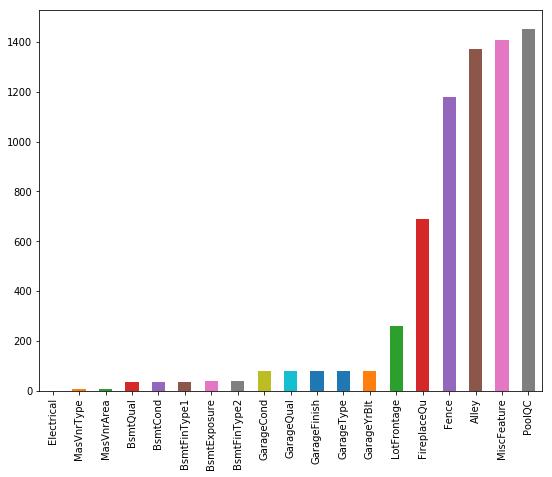

In [5]:
# Count and sort missing values
missing = training.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
# display missing data
print(missing)
# vizualize the missing data
missing.plot.bar(figsize=(9,7))
plt.show()

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64


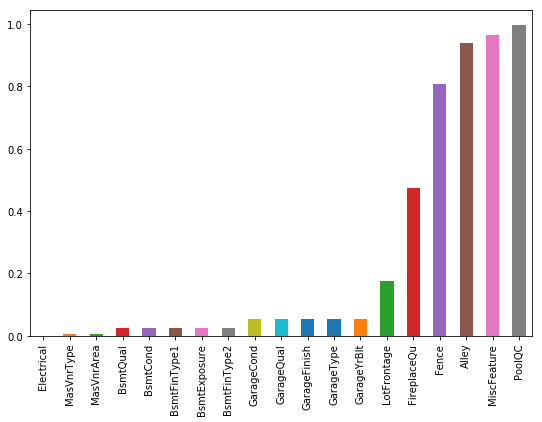

In [6]:
# create ratio of missing values to possible values
missing_ratio = missing/len(training)
# display ratio of values missing
print(missing_ratio)
# plot ratio of values missing
missing_ratio.plot.bar(figsize=(9,6))
plt.show()

In [7]:
# Find all properties that are missing 50% or more values
missing_50 = missing_ratio[missing_ratio>.5]
missing_50

Fence          0.807534
Alley          0.937671
MiscFeature    0.963014
PoolQC         0.995205
dtype: float64

In [8]:
len(training.columns)

81

In [9]:
for i in missing_50.keys():
    print("Dropping {}".format(i))
    training = training.drop([i], axis=1)
    testing = testing.drop([i], axis=1)

Dropping Fence
Dropping Alley
Dropping MiscFeature
Dropping PoolQC


In [10]:
len(training.columns)

77

With this, the four variables missing more than half of their values have been dropped from the dataset. Next, we'll need to replace missing values with something that our code can handle.

In [18]:
# Fill missing Qualitative Values with 'None'

temp_cols = ['FireplaceQu',
            'GarageType', 
            'GarageFinish', 
            'GarageQual', 
            'GarageCond', 
            'BsmtQual', 
            'BsmtCond', 
            'BsmtExposure', 
            'BsmtFinType1', 
            'BsmtFinType2',
            'MasVnrType',
            'MSSubClass'
]

for i in (temp_cols):
    training[i] = training[i].fillna('None')
    testing[i] = testing[i].fillna('None')

In [19]:
# Fill missing Quantitative Values with 0

temp_cols = ['GarageYrBlt', 
            'GarageArea', 
            'GarageCars',
            'BsmtFinSF1', 
            'BsmtFinSF2', 
            'BsmtUnfSF',
            'TotalBsmtSF', 
            'BsmtFullBath', 
            'BsmtHalfBath',
            'MasVnrArea'
    
]

for i in (temp_cols):
    training[i] = training[i].fillna(0)
    testing[i] = testing[i].fillna(0)   

In [20]:
# Fill in remaining variables with the most common value in the column

temp_cols = ['MSZoning', 
            'Electrical',
            'KitchenQual', 
            'Exterior1st', 
            'Exterior2nd',
            'SaleType'
]

for i in (temp_cols):
    training[i] = training[i].fillna(training[i].mode()[0])
    testing[i] = testing[i].fillna(testing[i].mode()[0])

In [21]:
# Fill in Functional variable with 'Typ' as suggested by other kernels

training['Functional'] = training['Functional'].fillna('Typ')
testing['Functional'] = testing['Functional'].fillna('Typ')

# Fill in LotFrontage variable with the median value for its neighborhood type
training['LotFrontage'] = training.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
testing['LotFrontage'] = testing.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Drop the Utilities column as each entry is identical
# Drop the ID column as it is unnecessary
training = training.drop(['Utilities','Id'],axis=1)
testing = testing.drop(['Utilities','Id'],axis=1)

In [22]:
# Next we display the training and testing sets to confirm that there are no remaining null values
training.info()
testing.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1460 non-null object
MasVnrArea       1460 no

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorc

### 2. Graphing the Target Variable

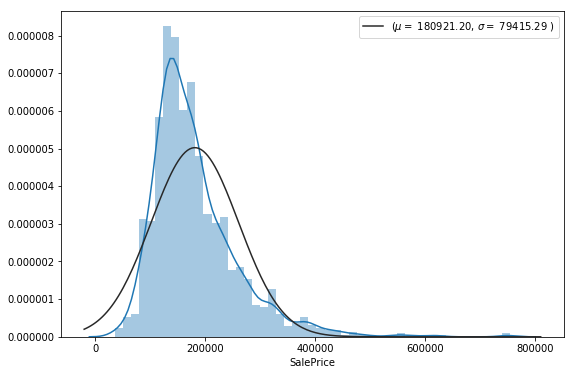

In [11]:
# Plot the target variable to determine its distribution
plt.subplots(figsize=(9,6))
sns.distplot(training['SalePrice'], fit=stats.norm)
(mu, sigma) = stats.norm.fit(training['SalePrice'])
plt.legend(['($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.show()

As can be seen above, the mean sale price is 180,921 with a sigma of 79,415. Additionally, the presence of outlier properties with sales prices above 400,000 is skewing the distribution to the right. We will need to normalize the distribution before continuing with our analysis. We can do this with a log transformation using log1p.

In [12]:
# since the prices are skewed, we will have to transform them into a normal distribution
training['LogPrice'] = np.log1p(training['SalePrice'])
# display the new data with log price appended
print(training['LogPrice'].head())

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: LogPrice, dtype: float64


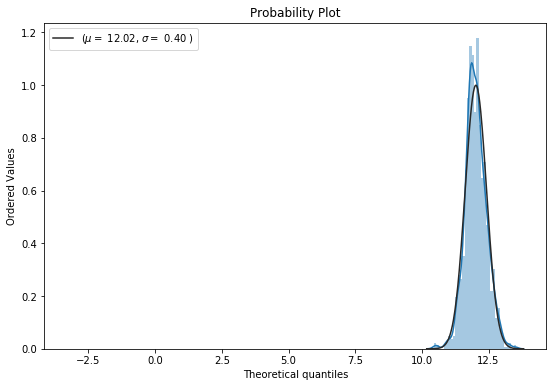

In [13]:
# Plot the new target variable
plt.subplots(figsize=(9,6))
sns.distplot(training['LogPrice'], fit=stats.norm)
(mu, sigma) = stats.norm.fit(training['LogPrice'])
plt.legend(['($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

# Display the probability plot
stats.probplot(training['LogPrice'], plot=plt)
plt.show()

The distribution of the log sales price appears normal and is no longer skewed. The distribution has a mean log sales price of 12.02 and a sigma of 0.40.